## Import Packages

In [1]:

# By: Darren Upton
# Modeled on Code By: Kishan Rajput

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
import pickle
import seaborn as sns

#Stuff for ML
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import random
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

from keras import backend as K

from matplotlib.colors import LogNorm


In [2]:
def Shower_Clustering(Shower_l, Shower_t, Shower_r, Shower=1):
    #Define Centers
    Shower_Centers = np.array([[-5.28,0.00,5.28], # X
                               [-3.05,6.10,-3.05], # Y
                               [3,3,3]]) #Z
    
    #Shower Modules
    #Adjust Based on MIP for Run
    if Shower==1:
        Shower_MIPs = [37.5,37.5,37.5]
    else:
        Shower_MIPs = [2.8,2.8,2.8]
    Modules = np.column_stack([Shower_l/Shower_MIPs[0], Shower_t/Shower_MIPs[1], Shower_r/Shower_MIPs[2]])
    
    #Calculations
    m_logWeightBase=3.6 #Wighting parameter
    Shower_Sums = Modules.sum(axis=1) #Get shower sum
    
    test_weights = m_logWeightBase + np.log(np.divide((Modules+0.0001), Shower_Sums[:,None], out=np.zeros_like(Modules), where=Shower_Sums[:,None]>0), 
                                            out=np.zeros_like(Modules), where=Shower_Sums[:,None]>0) #Get initial weights in 3-column array
    weights = test_weights*(test_weights > 0) #Check weights by keeping calculated weights > 0, which makes the rest 0
    weight_sums = weights.sum(axis=1) #Sum weights over 3 axes
    
    #Calc Shower Centers
    x = (Shower_Centers[0,:] * weights).sum(axis=1)
    y = (Shower_Centers[1,:] * weights).sum(axis=1)
    #z = (Shower_Centers[2,:] * weights).sum(axis=1)

    #Calc weighted centers
    Sh_x =  np.divide(x, weight_sums, out=np.zeros_like(x)+42, where=weight_sums!=0) + 42*(Shower_Sums==0)
    Sh_y =  np.divide(y, weight_sums, out=np.zeros_like(y)+42, where=weight_sums!=0) + 42*(Shower_Sums==0)
    #Sh_z =  z / weight_sums
    
    return Sh_x, Sh_y#, Sh_z



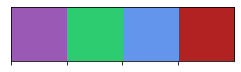

In [3]:
best_colors = ["#9b59b6", "#2ecc71", "cornflowerblue","firebrick"]
sns.set_palette(sns.color_palette(best_colors))
sns.palplot(sns.color_palette(best_colors))

## Import Data

In [ ]:
%%time 

raw_sim_df = pd.read_csv("Sim_CSV/Sim_Pencil.csv")

#Get HE electrons
#sim_df["pid"] = sim_df["pid"]*((sim_df["pid"]!=11) | (sim_df["ShowerSum"]<200))

#sim_df = (raw_sim_df[(raw_sim_df["ShowerSum"]<135*raw_sim_df["p"]) & (raw_sim_df["ShowerSum"]>135*(raw_sim_df["p"]-0.9))]).copy()

#Get Cluster Position
"""Sh_x, Sh_y = Shower_Clustering(raw_sim_df["Shower_l"], raw_sim_df["Shower_t"], raw_sim_df["Shower_r"])
raw_sim_df["Sh_X"] = Sh_x
raw_sim_df["Sh_Y"] = Sh_y

PreSh_x, PreSh_y = Shower_Clustering(raw_sim_df["PreSh_l"], raw_sim_df["PreSh_t"], raw_sim_df["PreSh_r"], Shower=0)
raw_sim_df["PreSh_X"] = PreSh_x
raw_sim_df["PreSh_Y"] = PreSh_y
"""
#Get Cher Array
#raw_Cher_df = pd.read_csv("Sim_CSV/Sim_CherChannels.csv", names=np.core.defchararray.add(np.array(16*["Cher"]), np.arange(0,16,1).astype(str)))
#raw_Cher_df["pid"] = raw_sim_df["pid"]
#Cher_df = raw_Cher_df[(raw_sim_df["PreShSum"]>0)]

sim_df = raw_sim_df[(raw_sim_df["PreShSum"]>0)]
sim_df

In [ ]:
plt.figure(dpi=150)
plt.xlabel("PID")

sns.histplot(sim_df, x=sim_df["pid"].astype(str))#, weights="# rate")

plt.yscale("log")

In [7]:
sim_df.groupby(["pid"]).count().iloc[:,0]

pid
-211.0    1641843
 11.0     1854656
 22.0     1565424
Name: # rate, dtype: int64

In [8]:
sim_df.columns

Index(['# rate', 'vx', 'vy', 'vz', 'px', 'py', 'pz', 'p', 'pid', 'PreShP',
       'PreShP_e', 'PreShPx', 'PreShPy', 'PreShPz', 'PreShtheta', 'PreShSum',
       'PreSh_l', 'PreSh_r', 'PreSh_t', 'ShowerSum', 'Shower_l', 'Shower_r',
       'Shower_t', 'SC_A_P', 'SC_A_Eendsum', 'SC_A_Eend', 'SC_D_P',
       'SC_D_Eendsum', 'SC_D_Eend', 'SC_C_P', 'SC_C_Eendsum', 'SC_C_Eend',
       'SC_B_P', 'SC_B_Eendsum', 'SC_B_Eend', 'SPD_P', 'SPD_Eendsum',
       'SPD_Eend', 'LASPD_P', 'LASPD_Eendsum', 'LASPD_Eend', 'GEM00_n',
       'GEM00_np', 'GEM00_Edep', 'GEM00_Edep2', 'GEM00_Edep3', 'GEM00_Etot',
       'GEM10_n', 'GEM10_np', 'GEM10_Edep', 'GEM10_Edep2', 'GEM10_Edep3',
       'GEM10_Etot', 'GEM01_n', 'GEM01_np', 'GEM01_Edep', 'GEM01_Edep2',
       'GEM01_Edep3', 'GEM01_Etot', 'GEM11_n', 'GEM11_np', 'GEM11_Edep',
       'GEM11_Edep2', 'GEM11_Edep3', 'GEM11_Etot', 'Npesum', 'theta', 'NCh',
       'Sh_X', 'Sh_Y', 'PreSh_X', 'PreSh_Y'],
      dtype='object')

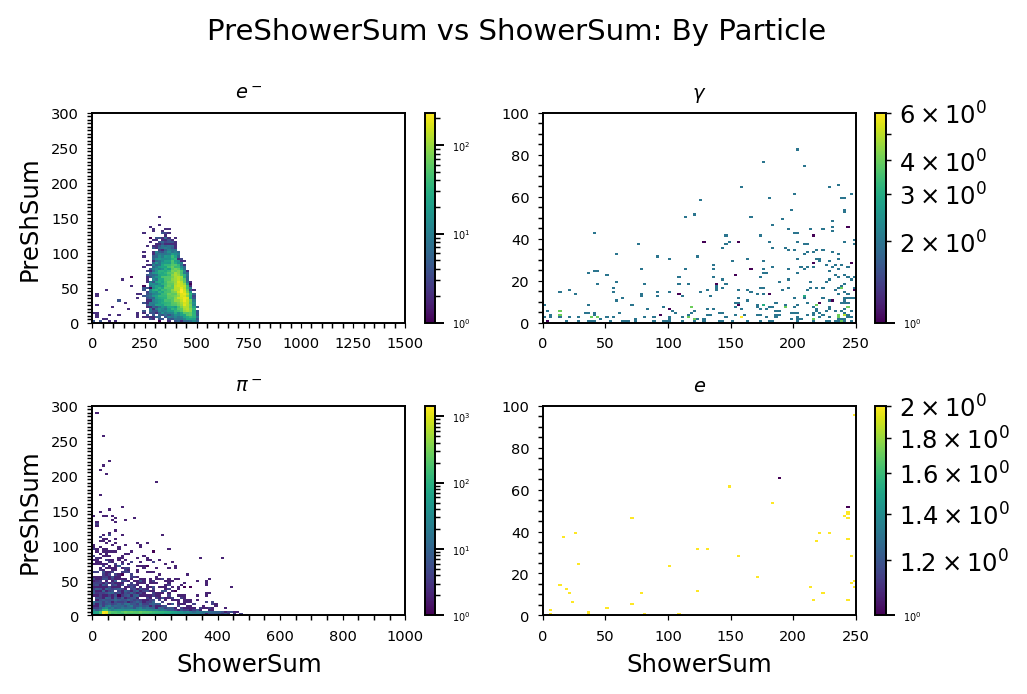

In [88]:
# Loop Over Shower Vals
columns =["ShowerSum","PreShSum"]
#bin_nums = [150,150,150,125,150]
limits = [[(0,1500),(0,300)],[(0,250),(0,100)],[(0,1000),(0,300)],[(0,250),(0,100)]] #[[(0,150),(0,100)],[(0,150),(0,100)],[(0,150),(0,150)],[(0,150),(0,100)]]
bins = [(100, 100), (100,100), (100,100), (100,100)]
x_bin = [50, 50,50,50]

#line_ests = [[[0,100],[100,0]],[[0,120],[130,0]],[[0,130],[120,0]],[[0,130],[120,0]]]

pcuts = [[0.1,0.3], [0.3,0.5], [0.5,0.7], [0.7,0.9]]

particles = ["$e^-$", "$\gamma$", "$\pi^-$", "$e$"]#np.unique(new_sim_df["pid"])
part_ids = [11, 22, -211, 11]

p_scaling = 1

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("PreShowerSum vs ShowerSum: By Particle")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8) #Angle, 
    
    plot_sim = sim_df[(sim_df["pid"]==part_ids[j]) & ((sim_df["p"]>3.5) & (sim_df["p"]<3.6))]

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(plot_sim[f"{columns[0]}"], plot_sim[f"{columns[1]}"], range=limits[j], 
                                                         #weights=plot_sim["rate"],
                     bins=bins[j], norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    #Scaling Line
    #axes[int(j/2),j%2].plot(*line_ests[j], color="lightgreen", label=f"Points: {line_ests[j][1][0]:n}, {line_ests[j][0][1]:n} \nSlope: {(line_ests[j][1][0]/line_ests[j][0][1]):2.3f}")
    #axes[int(j/2),j%2].legend(framealpha=1, prop={"size":6})
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,limits[j][0][1],x_bin[j]), minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,limits[j][1][1],5), minor=1)    
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
plt.savefig(f"Plots/NewCher_PreShSum_ShowerSum.pdf")   #AngleCut


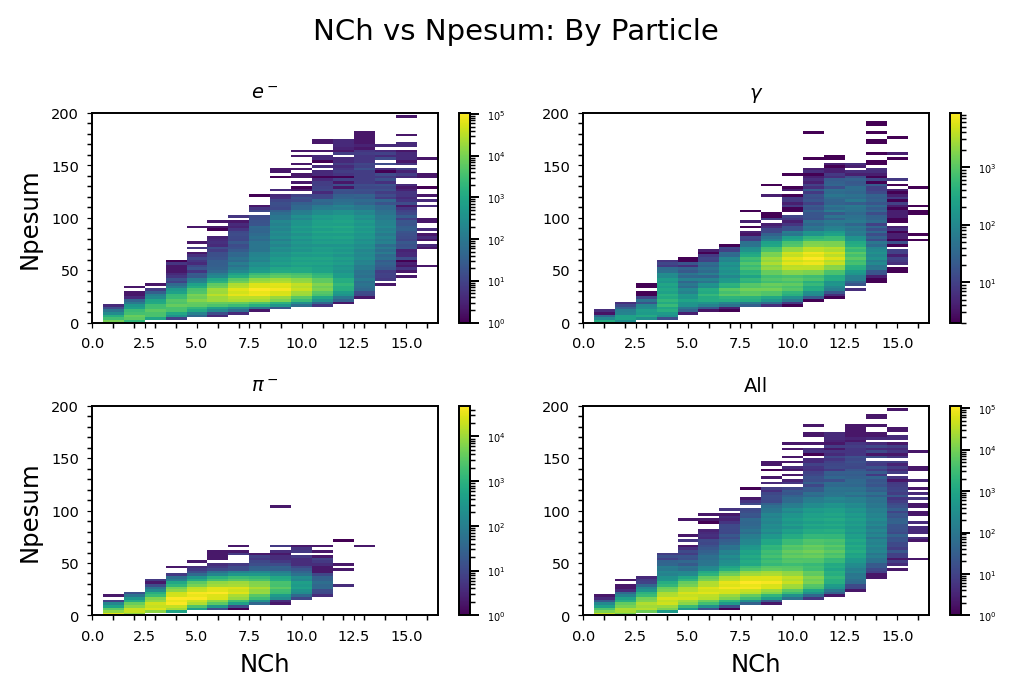

In [86]:
# Loop Over Shower Vals
columns =["NCh","Npesum"]
#bin_nums = [150,150,150,125,150]
limits = [[(0,1500),(0,250)],[(0,250),(0,100)],[(0,150),(0,100)],[(0,250),(0,100)]] #[[(0,150),(0,100)],[(0,150),(0,100)],[(0,150),(0,150)],[(0,150),(0,100)]]
bins = [(100, 100), (100,100), (100,100), (100,100)]
x_bin = [50, 5,5,5]

#line_ests = [[[0,100],[100,0]],[[0,120],[130,0]],[[0,130],[120,0]],[[0,130],[120,0]]]

pcuts = [[0.1,0.3], [0.3,0.5], [0.5,0.7], [0.7,0.9]]

particles = ["$e^-$", "$\gamma$", "$\pi^-$", "All"]#np.unique(new_sim_df["pid"])
part_ids = [11, 22, -211, 11]

p_scaling = 1

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("NCh vs Npesum: By Particle")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8) #Angle, 
    
    if j!=3:
        plot_sim = sim_df[(sim_df["pid"]==part_ids[j])]
    else:
        plot_sim = sim_df

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(plot_sim[f"{columns[0]}"], plot_sim[f"{columns[1]}"], range=limits[j], 
                                                         #weights=plot_sim["rate"],
                                                         bins=(np.arange(0,16.1,1)+0.5,np.arange(0,201,2.5)), 
                                                         norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    #Scaling Line
    #axes[int(j/2),j%2].plot(*line_ests[j], color="lightgreen", label=f"Points: {line_ests[j][1][0]:n}, {line_ests[j][0][1]:n} \nSlope: {(line_ests[j][1][0]/line_ests[j][0][1]):2.3f}")
    #axes[int(j/2),j%2].legend(framealpha=1, prop={"size":6})
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,17,1), minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,201,10), minor=1)    
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
#plt.savefig(f"Plots/NewCher_PreShSum_ShowerSum.pdf")   #AngleCut


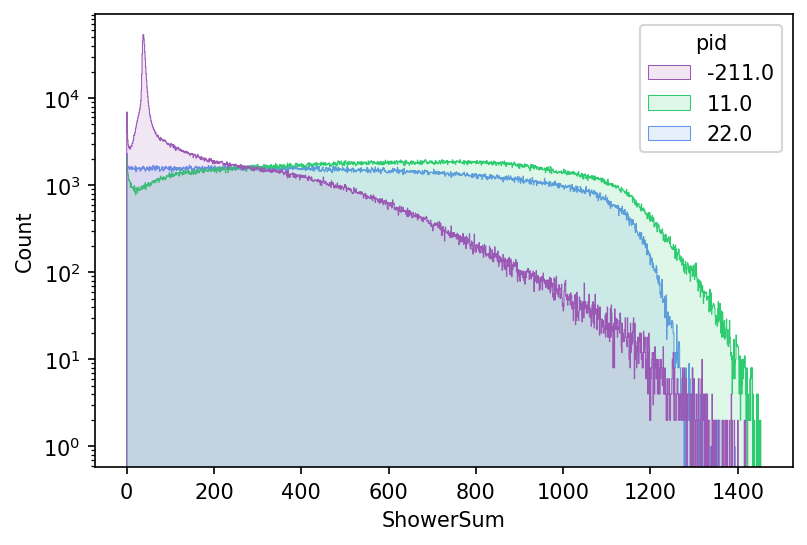

In [53]:
plt.figure(dpi=150)
sns.histplot(sim_df, x="ShowerSum", hue="pid", element="step", binwidth=1, #weights="# rate",
             palette=sns.color_palette(best_colors[:-1]), alpha=0.15, linewidth=0.5)

plt.yscale("log")

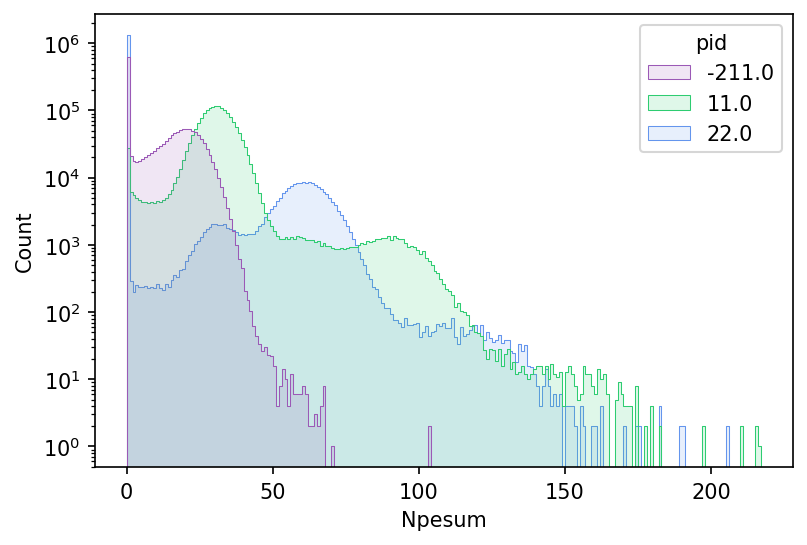

In [52]:
plt.figure(dpi=150)
sns.histplot(sim_df, x="Npesum", hue="pid", element="step", binwidth=1, #weights="# rate",
             palette=sns.color_palette(best_colors[:-1]), alpha=0.15, linewidth=0.5)

#plt.vlines(20, 1, 10**4)

plt.yscale("log")

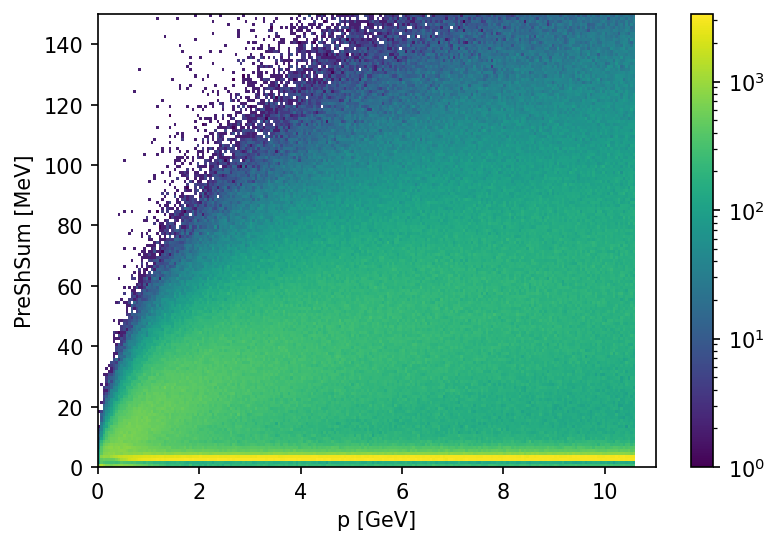

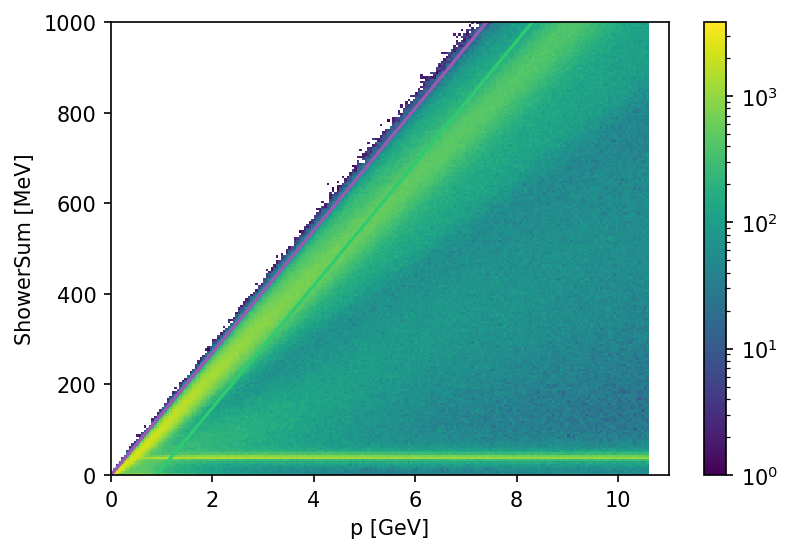

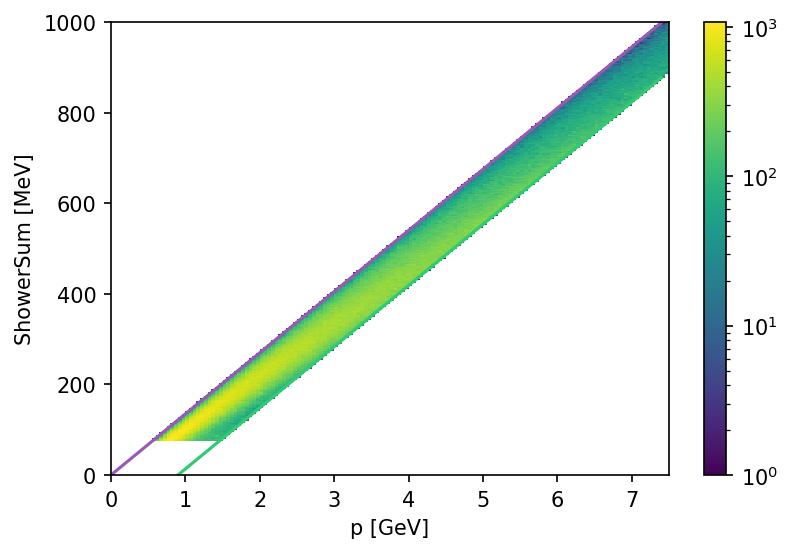

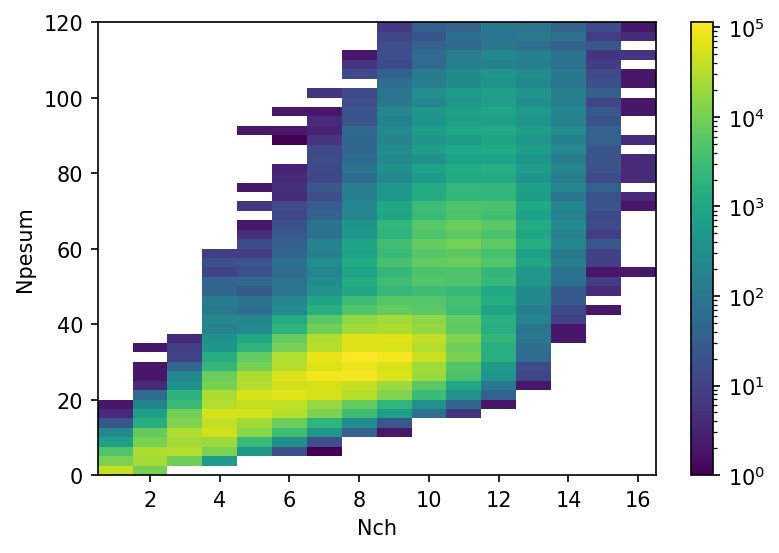

In [15]:
plt.figure(dpi=150)
plt.xlabel("p [GeV]")
plt.ylabel("PreShSum [MeV]")

plt.hist2d(sim_df["p"], sim_df["PreShSum"], bins=(np.arange(0,11.01,.05),np.arange(0,151,1)),norm=LogNorm())

plt.colorbar()
plt.show()

plt.figure(dpi=150)
plt.xlabel("p [GeV]")
plt.ylabel("ShowerSum [MeV]")

plt.hist2d(sim_df["p"], sim_df["ShowerSum"], bins=(np.arange(0,11.01,.05),np.arange(0,1001,5)),norm=LogNorm())

p_vals = np.arange(0,11.5,.1)
plt.plot(p_vals,(p_vals-0*.15)*135)
plt.plot(p_vals,(p_vals-.9)*135)

plt.colorbar()
plt.show()

plt.figure(dpi=150)
plt.xlabel("p [GeV]")
plt.ylabel("ShowerSum [MeV]")

plt.hist2d(sim_df["p"][(sim_df["ShowerSum"]>75) & (sim_df["ShowerSum"]<135*sim_df["p"]) & (sim_df["ShowerSum"]>135*(sim_df["p"]-0.9))], 
           sim_df["ShowerSum"][(sim_df["ShowerSum"]>75) & (sim_df["ShowerSum"]<135*sim_df["p"]) & (sim_df["ShowerSum"]>135*(sim_df["p"]-0.9))], 
           bins=(np.arange(0,7.51,.05),np.arange(0,1001,2.5)),norm=LogNorm())

p_vals = np.arange(0,7.5,.1)
plt.plot(p_vals,(p_vals-0*.15)*135)
plt.plot(p_vals,(p_vals-.9)*135)

plt.colorbar()
plt.show()

plt.figure(dpi=150)
plt.xlabel("Nch")
plt.ylabel("Npesum")

plt.hist2d(sim_df["NCh"],#[(sim_df["ShowerSum"]>75*0) & (sim_df["ShowerSum"]<135*sim_df["p"]) & (sim_df["ShowerSum"]>135*(sim_df["p"]-0.9))], 
           sim_df["Npesum"],#[(sim_df["ShowerSum"]>75*0) & (sim_df["ShowerSum"]<135*sim_df["p"]) & (sim_df["ShowerSum"]>135*(sim_df["p"]-0.9))], 
           bins=(np.arange(0,16.1,1)+0.5,np.arange(0,121,2.5)),
           norm=LogNorm())

#p_vals = np.arange(0,7.5,.1)
#plt.plot(p_vals,(p_vals-0*.15)*135)
#plt.plot(p_vals,(p_vals-.9)*135)

plt.colorbar()
plt.show()

In [16]:
(sim_df[(sim_df["ShowerSum"]>75) & (sim_df["ShowerSum"]<135*sim_df["p"]) & (sim_df["ShowerSum"]>135*(sim_df["p"]-0.9))]).groupby(["pid"]).count().iloc[:,0]

pid
-211.0     29884
 11.0     871570
 22.0     515844
Name: # rate, dtype: int64

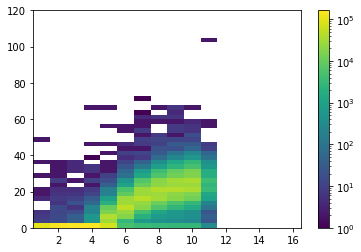

In [69]:
keeps = sim_df["pid"] == -211

plt.hist2d(sim_df["p"][keeps],#[(sim_df["ShowerSum"]>75*0) & (sim_df["ShowerSum"]<135*sim_df["p"]) & (sim_df["ShowerSum"]>135*(sim_df["p"]-0.9))], 
           sim_df["Npesum"][keeps],#[(sim_df["ShowerSum"]>75*0) & (sim_df["ShowerSum"]<135*sim_df["p"]) & (sim_df["ShowerSum"]>135*(sim_df["p"]-0.9))], 
           bins=(np.arange(0,16.1,1)+0.5,np.arange(0,121,2.5)),
           norm=LogNorm())

#p_vals = np.arange(0,7.5,.1)
#plt.plot(p_vals,(p_vals-0*.15)*135)
#plt.plot(p_vals,(p_vals-.9)*135)

plt.colorbar()
plt.show()

## Clustering

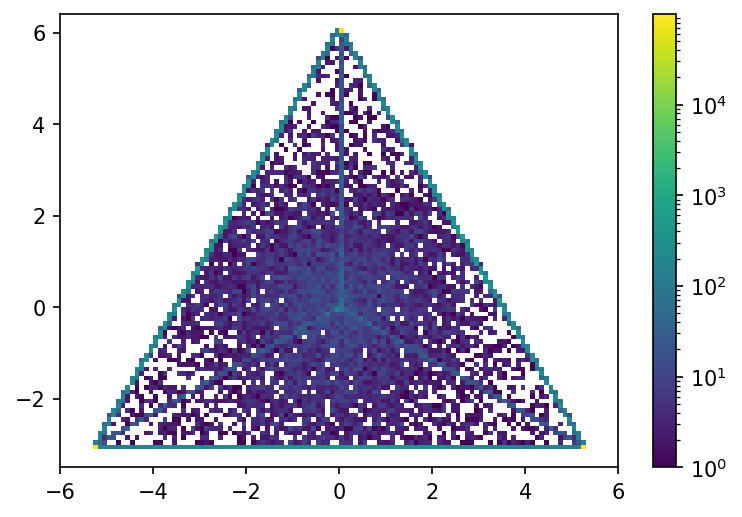

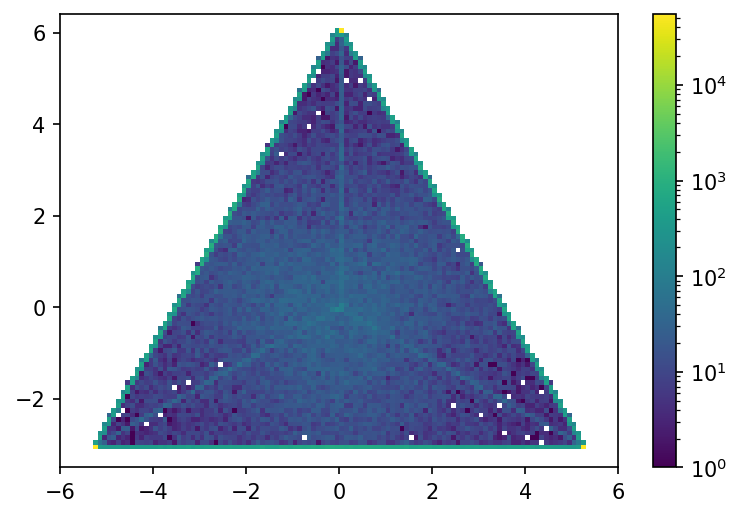

In [10]:
plt.figure(dpi=150)

plt.hist2d(sim_df["PreSh_X"],sim_df["PreSh_Y"], norm=LogNorm(), 
           bins=(np.arange(-6,6.1,0.1),np.arange(-3.5,6.5,.1)))

plt.colorbar()
plt.show()

plt.figure(dpi=150)

plt.hist2d(sim_df["Sh_X"],sim_df["Sh_Y"], norm=LogNorm(), 
           bins=(np.arange(-6,6.1,0.1),np.arange(-3.5,6.5,.1)))

plt.colorbar()

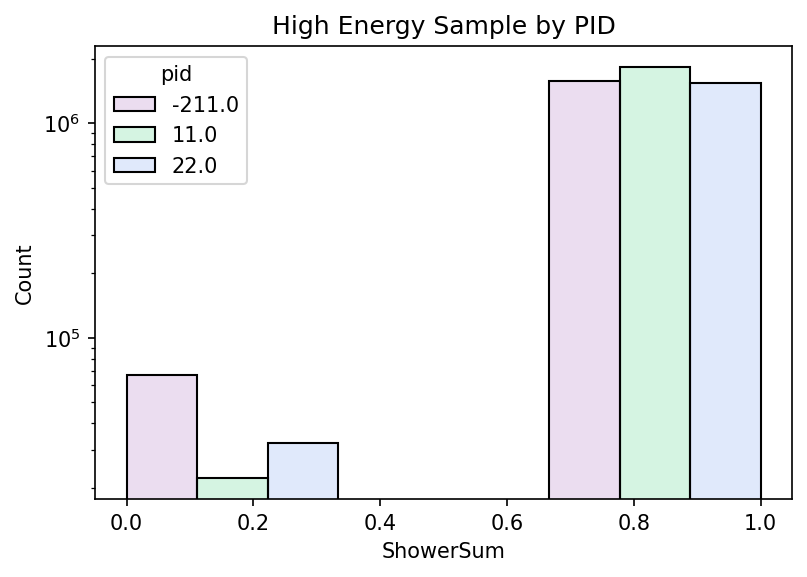

In [17]:
plt.figure(dpi=150)
plt.title("High Energy Sample by PID")
#plt.xlabel("PID")

sns.histplot(sim_df, x=(sim_df["ShowerSum"]>20).astype(int), hue="pid", weights="# rate", 
             multiple="dodge", palette=sns.color_palette(best_colors[:-1]), alpha=0.2, bins=3)

plt.yscale("log")

In [18]:
sim_df.columns

Index(['# rate', 'vx', 'vy', 'vz', 'px', 'py', 'pz', 'p', 'pid', 'PreShP',
       'PreShP_e', 'PreShPx', 'PreShPy', 'PreShPz', 'PreShtheta', 'PreShSum',
       'PreSh_l', 'PreSh_r', 'PreSh_t', 'ShowerSum', 'Shower_l', 'Shower_r',
       'Shower_t', 'SC_A_P', 'SC_A_Eendsum', 'SC_A_Eend', 'SC_D_P',
       'SC_D_Eendsum', 'SC_D_Eend', 'SC_C_P', 'SC_C_Eendsum', 'SC_C_Eend',
       'SC_B_P', 'SC_B_Eendsum', 'SC_B_Eend', 'SPD_P', 'SPD_Eendsum',
       'SPD_Eend', 'LASPD_P', 'LASPD_Eendsum', 'LASPD_Eend', 'GEM00_n',
       'GEM00_np', 'GEM00_Edep', 'GEM00_Edep2', 'GEM00_Edep3', 'GEM00_Etot',
       'GEM10_n', 'GEM10_np', 'GEM10_Edep', 'GEM10_Edep2', 'GEM10_Edep3',
       'GEM10_Etot', 'GEM01_n', 'GEM01_np', 'GEM01_Edep', 'GEM01_Edep2',
       'GEM01_Edep3', 'GEM01_Etot', 'GEM11_n', 'GEM11_np', 'GEM11_Edep',
       'GEM11_Edep2', 'GEM11_Edep3', 'GEM11_Etot', 'Npesum', 'theta', 'NCh',
       'Sh_X', 'Sh_Y', 'PreSh_X', 'PreSh_Y'],
      dtype='object')

In [19]:
sim_df.columns[[0, 15,16,17,18, 19,20,21,22, 24,27,30,33, 39, 41,47,53,59, -7,-5, -4,-3, -2,-1]]

#[[15,16,17,18, 19,21,22, 24,27,30,33, 39, 41,47,53,59, -7,-5]]

Index(['# rate', 'PreShSum', 'PreSh_l', 'PreSh_r', 'PreSh_t', 'ShowerSum',
       'Shower_l', 'Shower_r', 'Shower_t', 'SC_A_Eendsum', 'SC_D_Eendsum',
       'SC_C_Eendsum', 'SC_B_Eendsum', 'LASPD_Eendsum', 'GEM00_n', 'GEM10_n',
       'GEM01_n', 'GEM11_n', 'Npesum', 'NCh', 'Sh_X', 'Sh_Y', 'PreSh_X',
       'PreSh_Y'],
      dtype='object')

## Samples

In [29]:
# data = pd.concat([kaon_data, pion_data])
# data = shuffle(data)

data_np = sim_df.to_numpy()#(sim_df["pid"]!=111) sim_df[(sim_df["ShowerSum"]>1) & (sim_df["pid"]!=111) ].to_numpy()
#cher_np = Cher_df.to_numpy()

#X = data_np[:,[0, 4,5,6,7, 15,16,17,18, 19,21,22, 24,27,30,33, 39, 41,47,53,59, -7,-5]] #with momentum #np.delete(data_np, np.arange(0,9,1), 1)
               #15, 19, 24,27,30,33, 39, 41,47,53,59, -2]]
    
X = data_np[:,[0, 15,16,17,18, 19,20,21,22, 24,27,30,33, 39, 41,47,53,59, -7,-5, -4,-3, -2,-1]]
#X_Cher = cher_np[:,np.arange(0,16,1)]

#Full_X = np.column_stack([X,X_Cher])

Full_X = X

#Get Labels
y = data_np[:,8].astype(int)
y[y==11] = 0
y[y==22] = 1
y[y==-211] = 2

scaler = MinMaxScaler()
data = scaler.fit_transform(X)
# print(data.min(), data.max())

#train_data, test_data, train_labels, test_labels = train_test_split(data[:, :-1], data[:, -1], test_size=0.25, random_state=42)
train_data, test_data, train_labels, test_labels = train_test_split(data, y, test_size=0.2, random_state=42)

print("Train:", len(train_data))
print("Test:", len(test_data))

Train: 4049538
Test: 1012385


In [30]:
np.unique(y)

array([0, 1, 2])

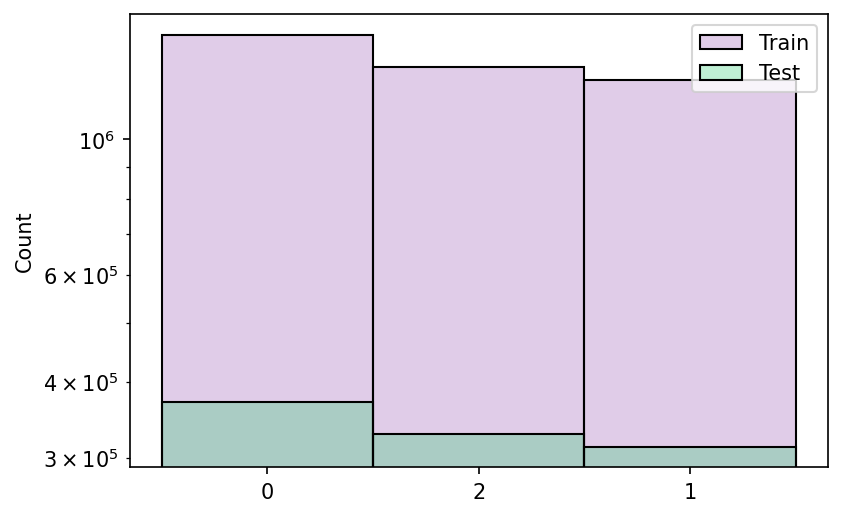

In [31]:
plt.figure(dpi=150)
sns.histplot(train_labels.astype(str),label="Train",alpha=0.3)
sns.histplot(test_labels.astype(str),label="Test",alpha=0.3,color=best_colors[1])

plt.legend()
plt.yscale("log")

## Meterics

In [32]:
#Electron efficiency
def electron_eff(y_true, y_pred):
    num_e = K.sum(y_true==0)
    pred_e = K.sum(y_pred==0)
    
    return pred_e/num_e

#Pion Rejection
def pi_reject(y_true, y_pred):
    num_pi = K.sum(y_true!=0)
    pi_pred_e = tf.keras.layers.Multiply()([y_pred, y_true])#K.sum((y_pred==0)*(y_true!=0))
    
    return 1-(pi_pred_e/num_pi)

model = 
solid.models.models.get_custom_model_v0(inp_shape=54)
model = get_custom_model_v0(inp_shape=(data).shape[-1])
model.summary()

#opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
opt = tf.keras.optimizers.SGD(lr=0.01)
model.compile(loss="binary_crossentropy", metrics=['accuracy'], optimizer=opt)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.85, patience=5, min_lr=1e-6, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=30, verbose=1,
                               baseline=None, restore_best_weights=True)


## Model

In [39]:
model = tf.keras.Sequential([
    Input(data[:,1:].shape[-1]),
    #Dense(1024, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(512, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(256, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(128, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(64, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(32, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(16, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(8, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(len(np.unique(y)), activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               12288     
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

In [40]:
#opt = tf.keras.optimizers.SGD(learning_rate=0.01) #10**-3 or 10**-4
opt = tf.keras.optimizers.Adam(learning_rate=10**-4)


model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True),
              metrics=['accuracy'])#, electron_eff, pi_reject])

In [41]:
np.unique(train_labels)

array([0, 1, 2])

## Training

In [65]:
%%time

version = "SULI_Week1_Pencil"#With_Momentum" #_Momentum_ShSum_Cut"

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=10**-5)
un_cts = np.unique(y, return_counts=1)

history = model.fit(train_data[:,1:], train_labels, epochs=2, batch_size=1000, 
                    #class_weight = {int(un_cts[0][0]):1/un_cts[1][0], int(un_cts[0][1]):1/un_cts[1][1]}, #int(un_cts[0][2]):1/un_cts[1][2]},
                    #{0:1.5, 1:30, 2:8}, #{0:10, 1:1, 2:10, 3:1}, #{0:1.5, 1:30, 2:8
                    #sample_weight = np.abs((train_labels-1.3)**-1),#train_labels,
                    callbacks=[reduce_lr],
                    validation_data=(test_data[:,1:], test_labels))


Epoch 1/2
4050/4050 [==============================] - 72s 18ms/step - loss: 0.0887 - accuracy: 0.9739 - val_loss: 0.0678 - val_accuracy: 0.9791
Epoch 2/2
4050/4050 [==============================] - 72s 18ms/step - loss: 0.0845 - accuracy: 0.9750 - val_loss: 0.0667 - val_accuracy: 0.9795
CPU times: user 10min 32s, sys: 45.1 s, total: 11min 17s
Wall time: 2min 25s


In [61]:
version = "SULI_Week1_Pencil_Train3"

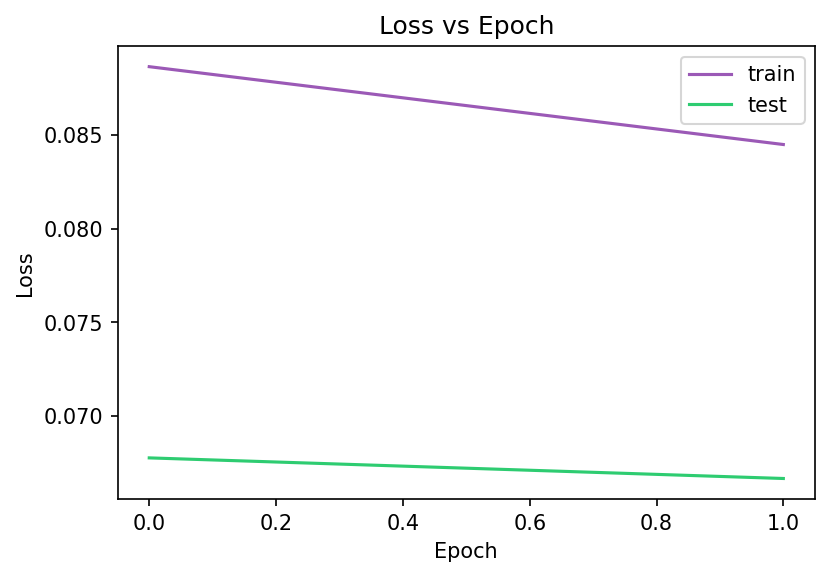

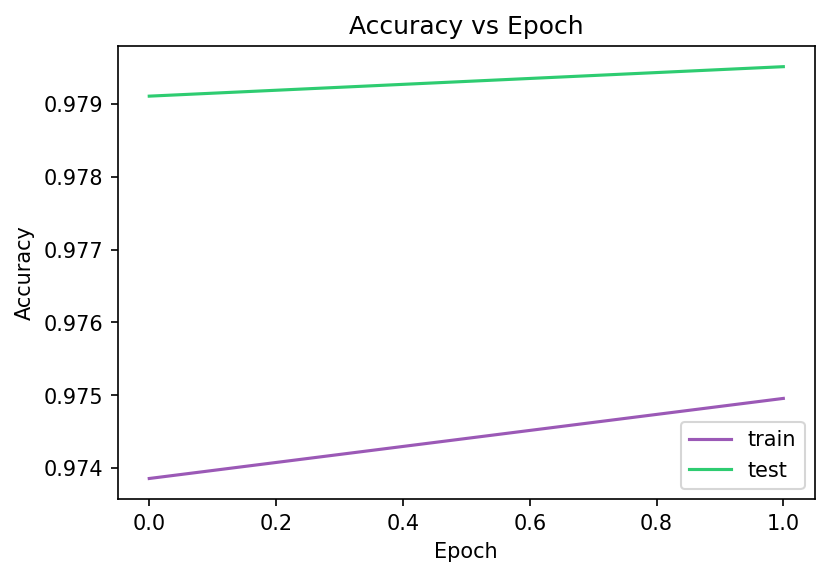

In [66]:
plt.figure(dpi=150)
plt.title("Loss vs Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.plot(np.arange(len(history.history["loss"])),history.history["loss"], label="train")
plt.plot(np.arange(len(history.history["val_loss"])),history.history["val_loss"], label="test")
plt.legend()
plt.savefig(f"Plots/Sim_Loss_{version}.pdf")
plt.show()

plt.figure(dpi=150)
plt.title("Accuracy vs Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.plot(np.arange(len(history.history["accuracy"])),history.history["accuracy"], label="train")
plt.plot(np.arange(len(history.history["val_accuracy"])),history.history["val_accuracy"], label="test")
plt.legend()
plt.savefig(f"Plots/Sim_Accuracy_{version}.pdf")
plt.show()

## Confusion Matrix

e Efficiency: 0.9764356611847693
Pi Rejection: 0.9920541898165766


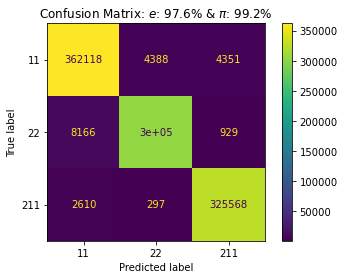

In [67]:
%%time

probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_data[:,1:])
results = np.argmax(predictions, axis=1)

e_eff = ((results==0)*(test_labels==0)).sum()/(test_labels==0).sum()
pi_rej = 1-(((results==0)*(test_labels==2)).sum()/(test_labels==2).sum())

print("e Efficiency:",e_eff)
print("Pi Rejection:",pi_rej)

cm=confusion_matrix(test_labels,results)#, sample_weight=test_data[:,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[11,22,211])
disp.plot()

plt.title(f"Confusion Matrix: $e$:{e_eff*100: .1f}% & $\pi$:{pi_rej*100: .1f}%")

plt.savefig(f"Plots/Sim_Confusion_SULI_Week1_{version}.pdf")



In [ ]:
(test_data[:,-5]>0) | ()

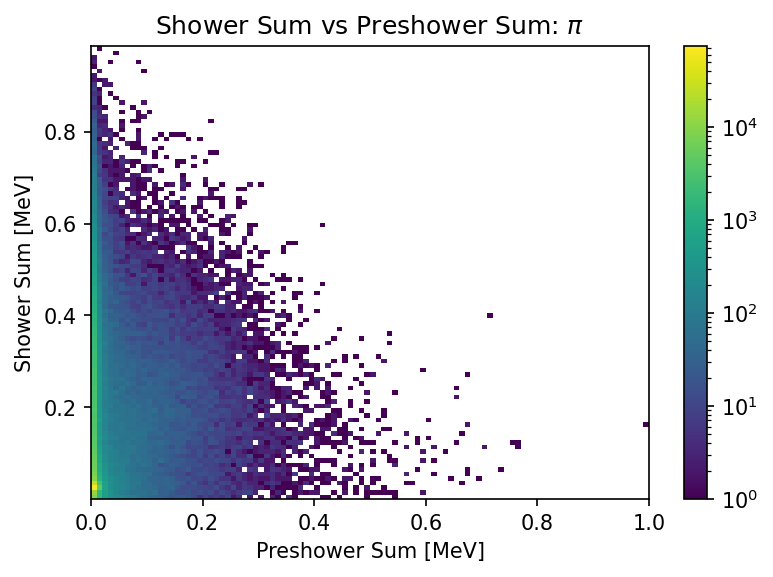

In [49]:
plt.figure(dpi=150)
plt.title("Shower Sum vs Preshower Sum: $\pi$")
plt.xlabel("Preshower Sum [MeV]")
plt.ylabel("Shower Sum [MeV]")

plt.hist2d(test_data[:,1][(results==2)], test_data[:,5][(results==2)], norm=LogNorm(),bins=100)

plt.colorbar()

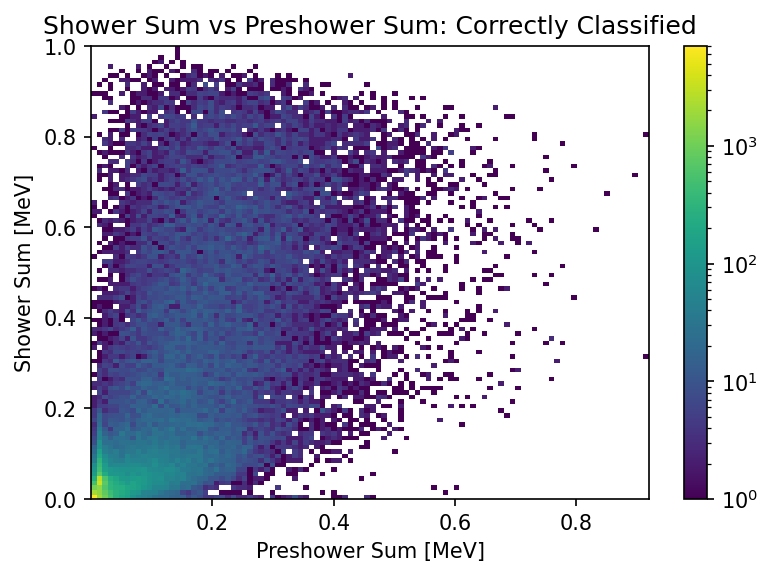

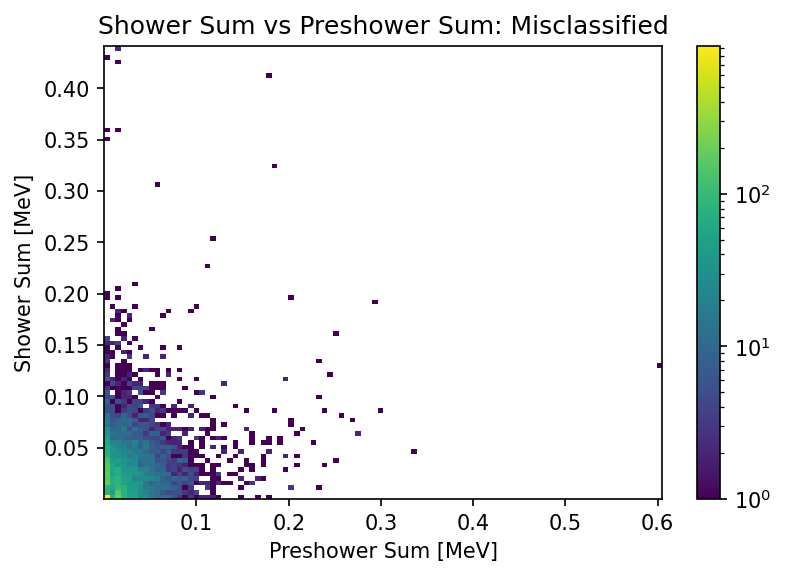

In [50]:
plt.figure(dpi=150)
plt.title("Shower Sum vs Preshower Sum: Correctly Classified")
plt.xlabel("Preshower Sum [MeV]")
plt.ylabel("Shower Sum [MeV]")

plt.hist2d(test_data[:,1][results==test_labels], test_data[:,5][results==test_labels], norm=LogNorm(),bins=100)

plt.colorbar()
plt.savefig("Plots/ShSum_PreShSum_Classified.pdf")
plt.show()

plt.figure(dpi=150)
plt.title("Shower Sum vs Preshower Sum: Misclassified")
plt.xlabel("Preshower Sum [MeV]")
plt.ylabel("Shower Sum [MeV]")

plt.hist2d(test_data[:,1][results!=test_labels], test_data[:,5][results!=test_labels], norm=LogNorm(), bins=100)
plt.colorbar()
plt.savefig("Plots/ShSum_PreShSum_Misclassified.pdf")

<Figure size 900x600 with 0 Axes>

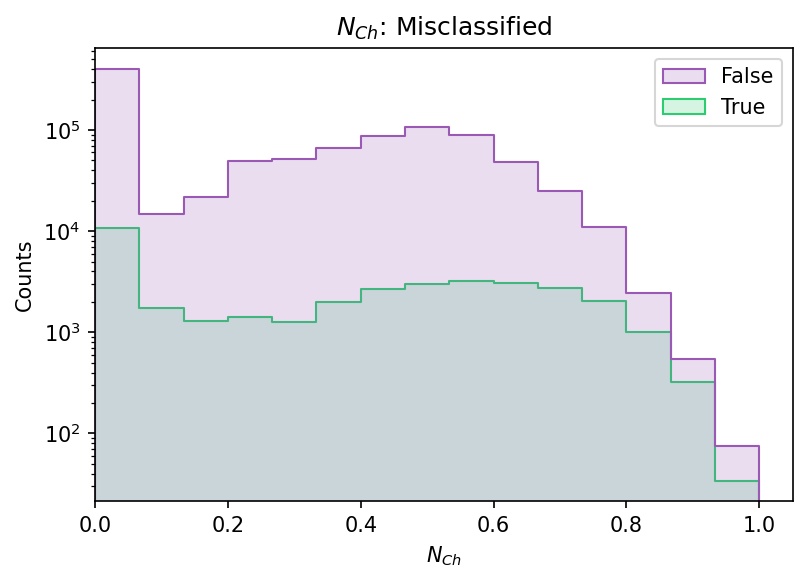

In [50]:
plt.figure(dpi=150)
plt.figure(dpi=150)
plt.title("$N_{Ch}$: Misclassified")
plt.xlabel("$N_{Ch}$")
plt.ylabel("Counts")

sns.histplot(test_data, x =test_data[:,-5], hue=(results!=test_labels), #weights=test_data[:,0],
             #palette=sns.color_palette(best_colors[:-1]), 
             element="step", alpha=0.2, binwidth=1/15)

plt.xlim(0,1.05)
plt.yscale("log")

plt.savefig("Plots/NCh_Misclassified.pdf")


KeyError: 'val_loss'

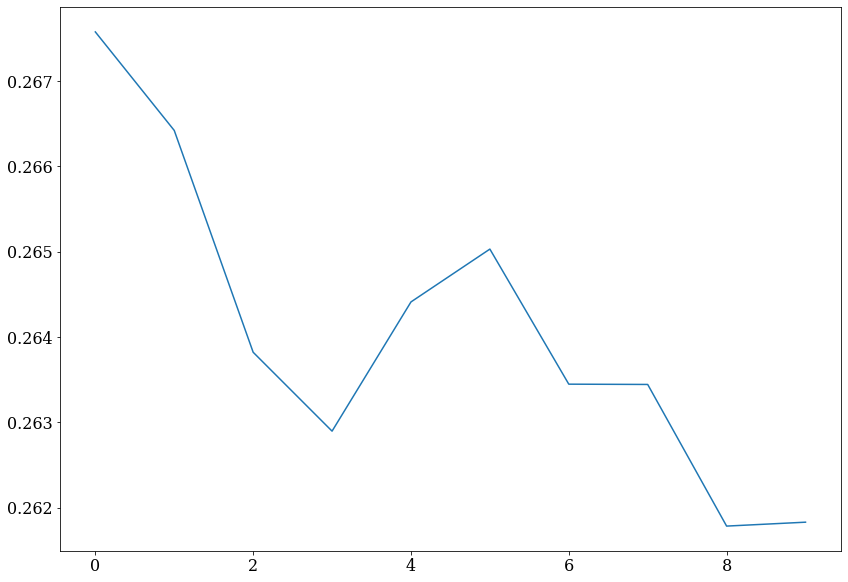

In [152]:
# model = tf.keras.models.load_model("/work/data_science/kishan/Hall-A/Solid_2022.02.07_noDecaytrack")
plt_metric(history.history, metric='loss', title='Loss curve')
plt.clf()
plt_metric(history.history, metric='accuracy', title='Accuracy curve')

In [121]:
history = model.fit(train_data, np.abs(np.round(train_labels)/50), epochs=10)#, batch_size=64, validation_data=(test_data, test_labels))#,callbacks=[reduce_lr, early_stopping])

# model.save("/work/data_science/kishan/Hall-A/Solid_2022.02.07_noDecaytrack")



Epoch 1/10
1981/1981 [==============================] - 2s 820us/step - loss: 0.4351 - accuracy: 0.0000e+00
Epoch 2/10
1981/1981 [==============================] - 2s 879us/step - loss: 0.2116 - accuracy: 0.0000e+00
Epoch 3/10
1586/1981 [=======================>......] - ETA: 0s - loss: 0.0421 - accuracy: 0.0000e+00

KeyboardInterrupt: 

KeyError: 'val_loss'

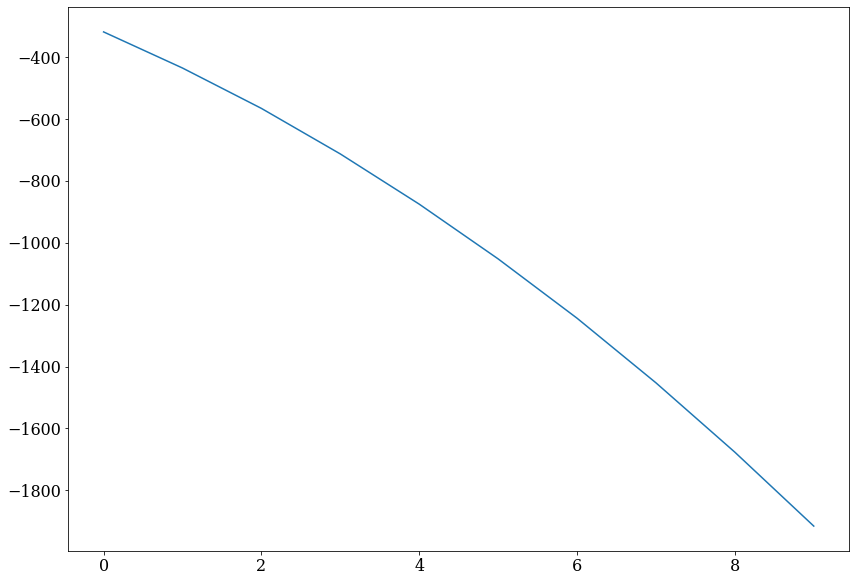

In [64]:
# model = tf.keras.models.load_model("/work/data_science/kishan/Hall-A/Solid_2022.02.07_noDecaytrack")
plt_metric(history.history, metric='loss', title='Loss curve', saveloc="3sector_nodecaytrack_loss.png")
plt.clf()
plt_metric(history.history, metric='accuracy', title='Accuracy curve', saveloc="3sector_nodecaytrack_acc.png")

In [66]:
test_preds

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

1.0 1.0
1.0 1.0
good_list 0
bad_list 0


<Figure size 1008x720 with 0 Axes>

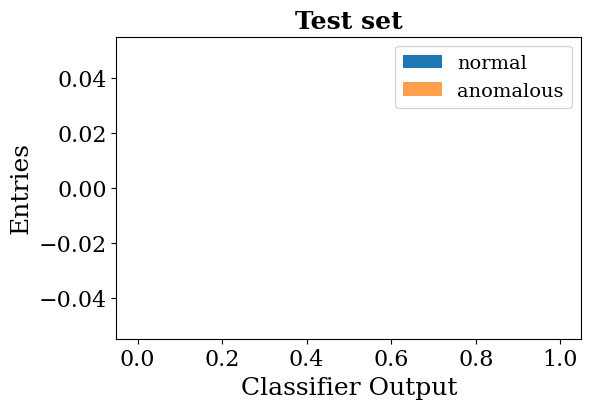

good_list 0
bad_list 0


<Figure size 1008x720 with 0 Axes>

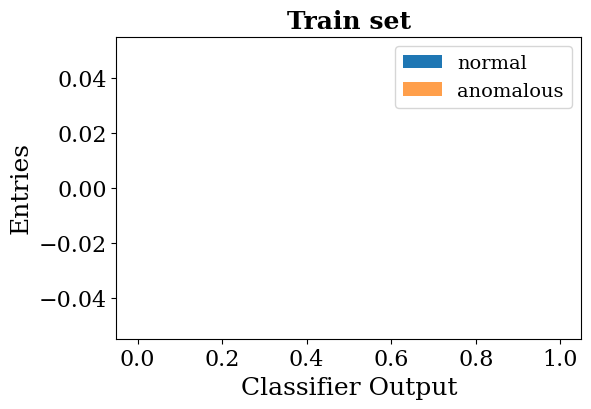

ValueError: multiclass format is not supported

<Figure size 1008x720 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [65]:
train_preds = model.predict(train_data)
test_preds = model.predict(test_data)
print(train_preds.min(), train_preds.max())
print(test_preds.min(), test_preds.max())

getSeparationPlot(test_labels, test_preds, "Test set", saveloc="Test_separation.png")
getSeparationPlot(train_labels, train_preds, "Train set", saveloc="Train_separation.png")

getROC([train_labels, test_labels], [train_preds, test_preds], ["Train", "Test"], saveloc="ROC.png")
getROC([train_labels, test_labels], [train_preds, test_preds], ["Train", "Test"], saveloc="ROC_zoomed.png",
       xlimit=[0, 0.1], ylimit=[0.8, 1.0])



In [ ]:
diff = test_labels - test_preds.flatten()
Ngood = abs(diff) < 0.5
goodDiff = diff[Ngood]
plt.hist(goodDiff, bins=100)
plt.show()
FOM = len(goodDiff)/len(diff)
print("FOM overall: ", FOM)
kaon_diff = diff[test_labels == 0]
pion_diff = diff[test_labels == 1]
# kaon_good_diff = kaon_diff[abs(kaon_diff) < 0.05]
# pion_good_diff = pion_diff[abs(pion_diff) < 0.05]
kaon_good_diff = kaon_diff[abs(kaon_diff) < 0.5]
pion_good_diff = pion_diff[abs(pion_diff) < 0.5]
print("Kaon efficiency: ", len(kaon_good_diff)/len(kaon_diff)*100)
print("Pion efficiency: ", len(pion_good_diff)/len(pion_diff)*100)

In [ ]:
model.evaluate(test_data,  test_labels, verbose=2)

In [ ]:
!ls -lh